In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Primer on a Few of the Most Popular Machine Learning Classifiers

Author: Greg Strabel
    
This notebook is a primer on a few of the most popular machine learning algorithms for classification problems. I first generate a dataset suitable for classification using the dataGenerator module posted on my GitHub page. For each of the machine learning algorithms, I give a brief introduction and then fit the model to the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataGenerator import classDataGenerator
from sklearn import preprocessing
from __future__ import print_function

In [2]:
catgVarLvls = [5, 8, 3]
ncat = len(catgVarLvls)
ncont = 3
n = ncont + ncat
N = 100000
reponseMean = 0.27
np.random.seed(123456)
trainPercent = 0.8
Ntrain = int(N * trainPercent)
df = classDataGenerator(catgVarLvls = catgVarLvls, ncont = ncont, N = N, responseMean = reponseMean)
train, test = df[:Ntrain], df[Ntrain:]

X_train = pd.get_dummies(train.loc[:,range(n)])
Y_train = train.response
scaler = preprocessing.StandardScaler().fit(X_train.values)
X_train_scaled = scaler.transform(X_train.values)
X_test = pd.get_dummies(test.loc[:,range(n)])
X_test_scaled = scaler.transform(X_test.values)
Y_test = test.response

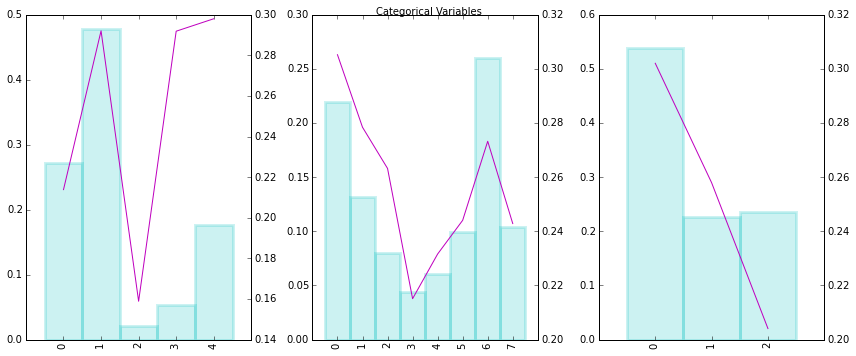

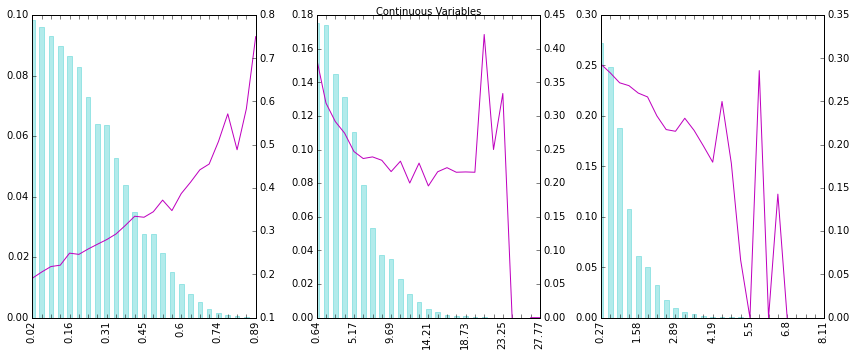

In [4]:
plt.close()
mplFig = plt.figure(figsize = (12,5)); mplFig.suptitle('Categorical Variables')
normalize = True
for i in range(ncat):
    plt.subplot(1,3,i+1); ax = plt.gca()
    train[i].value_counts(normalize = normalize).sort_index().\
        plot(kind = 'bar', ax = ax,alpha = 0.2, color = 'c', edgecolor = 'c', lw = '3', width =1)
    tx = ax.twinx()
    train.response.groupby(train[i]).mean().sort_index().\
        plot(ax = tx,color = 'm')
    plt.xlim([-1,len(train[i].value_counts())])
plt.tight_layout()

mplFig2 = plt.figure(figsize = (12,5)); mplFig2.suptitle('Continuous Variables')
for i in np.arange(ncat, n, dtype = int):
    plt.subplot(1,3,i-2); ax = plt.gca()
    ncuts = 25
    cuts, bins = pd.cut(train[i],ncuts, retbins = True, precision = 10)
    cuts.value_counts(normalize = normalize).\
        plot(kind = 'bar', ax = ax, alpha = 0.3, color = 'c', edgecolor = 'c')
    tx = ax.twinx()
    train.response.groupby(cuts).mean().plot(ax = tx, color = 'm')
    ax.set_xticklabels(
    [round((bins[i+1]+bins[i])/2,2) if i % (ncuts / 6) == 0 else '' for i in range(len(bins)-1)]
    )
plt.tight_layout()

The first machine learning classifier we will consider is gradient boosted trees. Leo Breiman has called gradient boosting, and specifically AdaBoost, the 'best off-the-shelf classifier in the world'. In my experience, it can be quite hard to beat a well-tuned GBM and the spate of Kaggle competitions won by GBMs further attest to their power. If you are familiar with classical gradient descent algorithms in mathematical optimization theory, the intuition behind GBM will be familiar. The following is a brief introduction to the idea of gradient boosting.

Given $N$ observations $\{y_i,x_i\}_{i=1}^{N}$, a class of predictor functions $F$, and a loss function $L$, the objective is to 
solve $$\underset{f \in F}{argmin}\sum\limits_{i=1}^N L(y_i, f(x_i))$$

In the case of gradient boosting, attention is restricted to the class of functions $F$ which can be written as the finite sum of weak learners from a given set of weak learners, typically decision trees. Gradient boosting then attempts to solve this problem iteratively.
At iteration $k+1$ we have an approximate solution $f_k$
from the previous iteration and we look to find a function $\eta_{k+1}$ such that the new approximate solution is
$f_{k+1}=f_k+\eta_{k+1}$. Let $\vec{f}_k$ be the $N$ x $1$ vector defined by $\vec{f}_{k,i} = f_k(x_i)$ and
let $\vec{\eta}$ also be an $N$ x $1$ vector. The derivative of the expression
$$\sum\limits_{i=1}^N L(y_i, \vec{f}_{k,i} + \vec{\eta})$$ with respect to $\vec{\eta}$, evaluated at
$\vec{\eta} = \vec{0}$, is an $N$ x $1$ vector, $\vec{\epsilon_{k+1}}$,
with $i^{th}$ element equal to $L_2(y_i, \vec{f}_{k,i})$. Regarding the objective function as a function of $\vec{\eta}$,
the direction of steepest descent is $-\vec{\epsilon_{k+1}}$, i.e. the negative of the gradient.
Gradient boosting takes $-\vec{\epsilon_{k+1}}$ as the target and fits a weak learner to it using $\vec{x}$ as predictors.
Calling this weak learner $\eta_{k+1}$, we set $f_{k+1} = f_k + \gamma\eta_{k+1}$, where $\gamma \in (0,1]$ is the learning rate.
We then continue to the next iteration. After $K$ iterations, the process is stopped,
yielding a final gradient boosting estimator $f_K$.

Fitting a GBM classifier in python requires only a few lines of code:

C:\Users\Gregory\Anaconda\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Gini: 0.16057257768


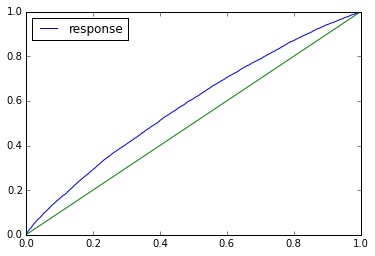

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1,
    max_depth=1, random_state=0).fit(X_train_scaled, Y_train.values)
#clf.score(X_test.values, Y_test.values)  

testLiftGBC = test.response.to_frame()
testLiftGBC['probsGBC'] = clf.predict_proba(X_test_scaled)[:,1]
plt.figure()
tLGBC = testLiftGBC.sort(columns='probsGBC', ascending = False).reset_index().response.cumsum().to_frame()
tLGBC.index = (1.0*tLGBC.index)/len(tLGBC); tLGBC.response = tLGBC.response/tLGBC.response.max()
tLGBC.plot(ax=plt.gca())
plt.gca().plot(np.array([0,1]),np.array([0,1]))
print('Gini:',2*(tLGBC.response - tLGBC.index).sum()/len(tLGBC))

In [32]:
suspectedBetaVars = [3] # variables that appear to follow a beta distribution
suspectedGammaVars = [4,5] # variables that appear to follow a gamma distribution

import scipy.stats as stats
from scipy.optimize import minimize

def betaNLL(x,a,b):
    return -stats.beta.logpdf(x,a=a,b=b).sum()

def gammaNLL(x,a,scale):
    return -stats.gamma.logpdf(x,a=a,scale=scale).sum()

In [33]:
pgi = {}; pgni = {}
for i in range(ncat):
    probsgi = train.loc[train.response == 1, i].value_counts(normalize = normalize).\
        sort_index().reset_index().rename(columns = {'index':'level',i:'prob'})
    pgi[i] = probsgi
    probsgni = train.loc[train.response == 0, i].value_counts(normalize = normalize).\
        sort_index().reset_index().rename(columns = {'index':'level',i:'prob'})
    pgni[i] = probsgni

for i in np.arange(ncat,n, dtype = int):
    if i in suspectedBetaVars:
        pgi[i] = minimize(lambda p: betaNLL(train.loc[train.response == 1,i].values,p[0],p[1]),
                  np.array([2,5]), method='Nelder-Mead').x
        pgni[i] = minimize(lambda p: betaNLL(train.loc[train.response == 0,i].values,p[0],p[1]),
                  np.array([2,5]), method='Nelder-Mead').x
    if i in suspectedGammaVars:
        pgi[i] = minimize(lambda p: gammaNLL(train.loc[train.response == 1,i].values,p[0],p[1]),
                  np.array([1,1]), method='Nelder-Mead').x
        pgni[i] = minimize(lambda p: gammaNLL(train.loc[train.response == 0,i].values,p[0],p[1]),
                  np.array([1,1]), method='Nelder-Mead').x

<IPython.core.display.Javascript object>


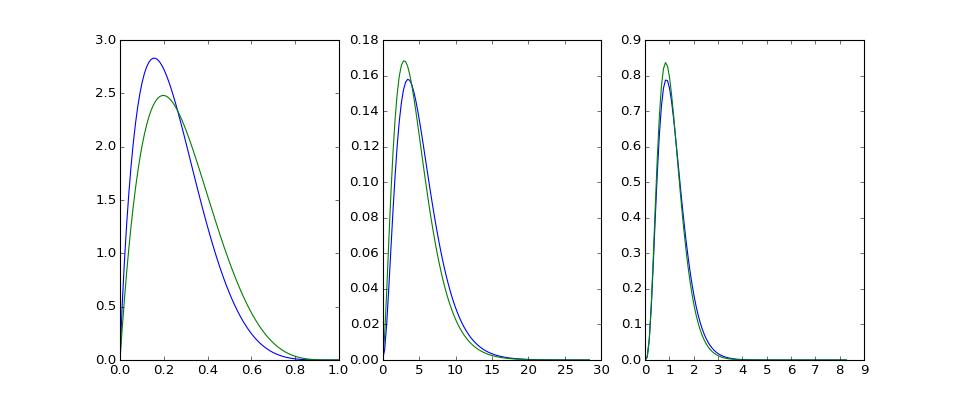

In [34]:
densityPlot = plt.figure(figsize = (12,5))
for i in range(ncont):
    plt.subplot(1,ncont,i+1)
    if i + ncat in suspectedBetaVars:
        x = np.linspace(0,1,100); y1 = stats.beta.pdf(x,a=pgi[i+ncat][0],b=pgi[i+ncat][1])
        y0 = stats.beta.pdf(x,a=pgni[i+ncat][0],b=pgni[i+ncat][1])
        plt.gca().plot(x,y0,x,y1)
    if i + ncat in suspectedGammaVars:
        x = np.linspace(0,train[i+ncat].max(),100); y1 = stats.gamma.pdf(x,a=pgi[i+ncat][0],scale=pgi[i+ncat][1])
        y0 = stats.gamma.pdf(x,a=pgni[i+ncat][0],scale=pgni[i+ncat][1])
        plt.gca().plot(x,y0,x,y1)

In [35]:
probXgivenIssue = np.ones(len(test)).reshape(-1,1)
probXgivenNotIssue = np.ones(len(test)).reshape(-1,1)
import time
for i in range(ncat):
    startTime = time.time()
    probXgivenIssue = probXgivenIssue * pd.merge(test.loc[:,i].to_frame(),pgi[i],how='left', left_on = i, right_on='level').\
            prob.values.reshape(-1,1)
    probXgivenNotIssue = probXgivenIssue * pd.merge(test.loc[:,i].to_frame(),pgni[i],how='left', left_on = i, right_on='level').\
            prob.values.reshape(-1,1)
    endTime = time.time()
    print('Variable',i,'took',endTime - startTime,'seconds')
for i in np.arange(ncat,n,dtype = int):
    startTime = time.time()
    if i in suspectedBetaVars:
        probXgivenIssue = probXgivenIssue * stats.beta.pdf(test[i].values,a=pgi[i][0],b=pgi[i][1]).reshape(-1,1)
        probXgivenNotIssue = probXgivenNotIssue * stats.beta.pdf(test[i].values,a=pgni[i][0],b=pgni[i][1]).reshape(-1,1)
    if i in suspectedGammaVars:
        probXgivenIssue = probXgivenIssue * stats.gamma.pdf(test[i].values,a=pgi[i][0],scale=pgi[i][1]).reshape(-1,1)
        probXgivenNotIssue = probXgivenNotIssue * stats.gamma.pdf(test[i].values,a=pgni[i][0],scale=pgni[i][1]).reshape(-1,1)
    endTime = time.time()
    print('Variable',i,'took',endTime - startTime,'seconds')

Variable 0 took 0.0309998989105 seconds
Variable 1 took 0.0400002002716 seconds
Variable 2 took 0.0199999809265 seconds
Variable 3 took 0.0179998874664 seconds
Variable 4 took 0.00799989700317 seconds
Variable 5 took 0.00500011444092 seconds


<IPython.core.display.Javascript object>


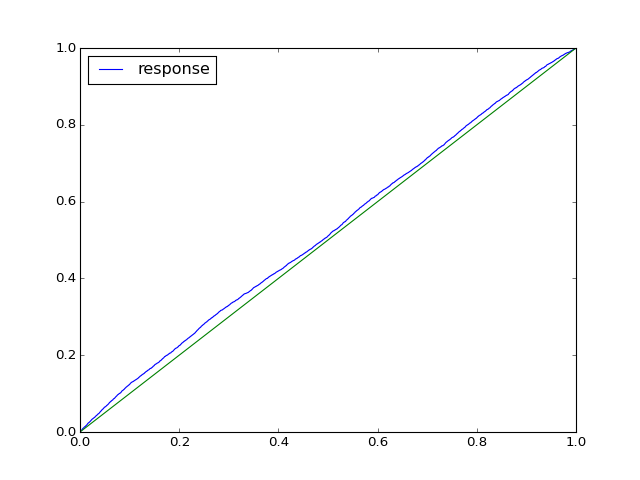

C:\Users\Gregory\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Gini:  0.0366028038242


In [45]:
testLift = test.response.to_frame()
testLift['probsNB'] = train.response.mean()*probXgivenIssue / \
    (probXgivenIssue * train.response.mean() + probXgivenNotIssue * (1 - train.response.mean()))
plt.figure()
tL = testLift.sort(columns='probsNB', ascending = False).reset_index().response.cumsum().to_frame()
tL.index = 1.0*(tL.index)/len(tL); tL.response = tL.response/tL.response.max()
tL.plot(ax=plt.gca())
plt.gca().plot(np.array([0,1]),np.array([0,1]))
print('Gini: ',2*(tL.response - tL.index).sum()/len(tL))

<IPython.core.display.Javascript object>


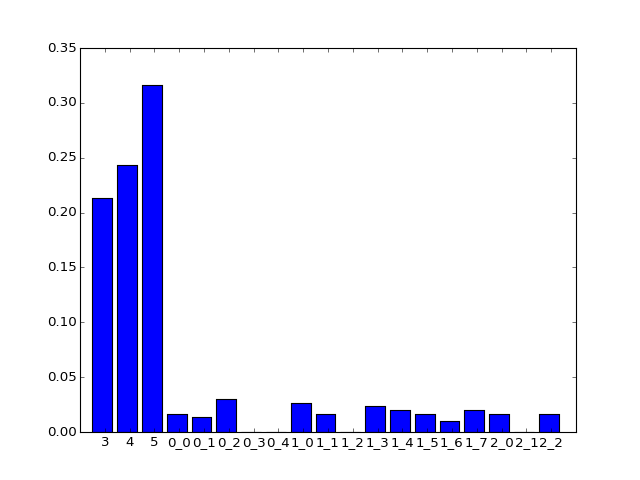

In [49]:
#clf.feature_importances_
plt.close()
plt.figure()
y = clf.feature_importances_
plt.bar(np.array(range(len(y)))-0.5,y)
plt.xlim([-1,len(y)])
plt.gca().set_xticks(np.array(range(len(y))))
plt.gca().set_xticklabels(X_train.columns.tolist())

In [22]:
pd.get_dummies(train.head().loc[:,range(3)],prefix_sep=':')

,0:0,0:1,0:2,0:3,0:4,1:0,1:1,1:2,1:3,1:4,1:5,1:6,1:7,2:0,2:1,2:2
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [9]:
import string

In [13]:
'ab'.partition(':')

('ab', '', '')

In [32]:
from sklearn.linear_model import LogisticRegressionCV
clf_l1_LR = LogisticRegressionCV(penalty='l2', tol=0.01)
clf_l1_LR.fit(X_train.values, Y_train.values)
clf_l1_LR_preds = clf_l1_LR.predict_proba(X_test.values)

<IPython.core.display.Javascript object>


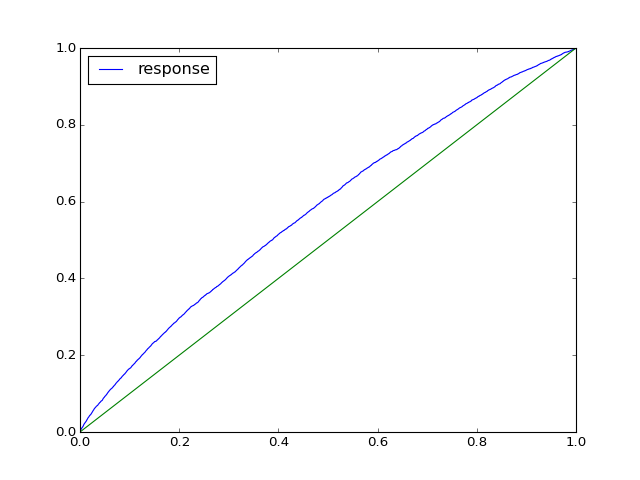

C:\Users\Gregory\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Gini: 0.163009569774


In [33]:
testLiftLR = test.response.to_frame()
testLiftLR['probsLR'] = clf_l1_LR.predict_proba(X_test.values)[:,1]
plt.figure()
tLLR = testLiftLR.sort(columns='probsLR', ascending = False).reset_index().response.cumsum().to_frame()
tLLR.index = (1.0*tLLR.index)/len(tLLR); tLLR.response = tLLR.response/tLLR.response.max()
tLLR.plot(ax=plt.gca())
plt.gca().plot(np.array([0,1]),np.array([0,1]))
print('Gini:',2*(tLLR.response - tLLR.index).sum()/len(tLLR))

In [34]:
clf_l1_LR.coef_

array([[ 1.37358777, -0.02371848, -0.15211005, -0.08977348,  0.24333746,
        -0.55254222,  0.18596749,  0.1980428 ,  0.27325867,  0.12379385,
         0.041649  , -0.22793165, -0.136885  , -0.06492019,  0.07605022,
        -0.09998284,  0.16447218,  0.02741299, -0.20685311]])

In [41]:
from sknn.mlp import Classifier, Layer
import time

startTime = time.time()
nn = Classifier(
    layers=[
        Layer("Sigmoid", units=6),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=25)
nn.fit(X_train, Y_train)

endTime = time.time()
print('Fitting Neural Network took',(endTime - startTime)/60, 'minutes')

Fitting Neural Network took 21.146449999 minutes


[(20000L, 2L)]


<IPython.core.display.Javascript object>


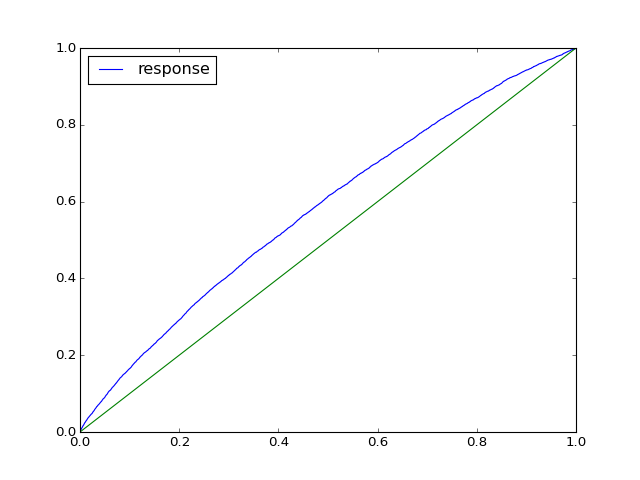

C:\Users\Gregory\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Gini: 0.162184675492


In [40]:
testLiftNN = test.response.to_frame()
testLiftNN['probsNN'] = nn.predict_proba(X_test.values)[:,1]
plt.figure()
tLNN = testLiftNN.sort(columns='probsNN', ascending = False).reset_index().response.cumsum().to_frame()
tLNN.index = (1.0*tLNN.index)/len(tLNN); tLNN.response = tLNN.response/tLNN.response.max()
tLNN.plot(ax=plt.gca())
plt.gca().plot(np.array([0,1]),np.array([0,1]))
print('Gini:',2*(tLNN.response - tLNN.index).sum()/len(tLNN))

In [14]:
import theano
import theano.tensor as T
import lasagne

input_var = theano.tensor.matrix('input_var')
target_var = T.ivector('targets')


l_in = lasagne.layers.InputLayer(shape=(None,X_train.shape[1]), input_var = input_var)

l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

l_hid1 = lasagne.layers.DenseLayer(
    l_in_drop, num_units = 6,
    nonlinearity = lasagne.nonlinearities.sigmoid,
    W=lasagne.init.GlorotNormal())

l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.2)

l_hid2 = lasagne.layers.DenseLayer(
    l_hid1_drop, num_units = 3,
    nonlinearity = lasagne.nonlinearities.sigmoid,
    W=lasagne.init.GlorotNormal())

l_out = lasagne.layers.DenseLayer(l_hid2, num_units = 2,
                                  nonlinearity = lasagne.nonlinearities.softmax)

prediction = lasagne.layers.get_output(l_out, input_var)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(l_out, trainable=True)

updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(l_out, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

for epoch in range(501):
    train_err = train_fn(X_train.values, Y_train.values)
    err, acc = val_fn(X_test.values, Y_test.values)
    #err, acc = 3, 2
    if epoch % 100 == 0:
        print('For epoch', epoch, ', training error is', train_err, 'and '+
        'validation error and accuracy are', err, 'and', acc)


For epoch 0 , training error is 0.596211109843 and validation error and accuracy are 0.595646103273 and 0.72805
For epoch 100 , training error is 0.585125029899 and validation error and accuracy are 0.584170485488 and 0.72805
For epoch 200 , training error is 0.584308334474 and validation error and accuracy are 0.583913830977 and 0.72805
For epoch 300 , training error is 0.583204616611 and validation error and accuracy are 0.583740438826 and 0.72805
For epoch 400 , training error is 0.582511381915 and validation error and accuracy are 0.583563550876 and 0.72805
For epoch 500 , training error is 0.582295260499 and validation error and accuracy are 0.583379631611 and 0.72805


C:\Users\Gregory\Anaconda\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Gini: 0.0809341698842


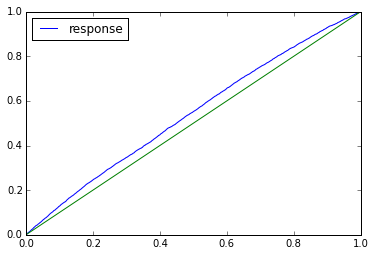

In [15]:
#test_prediction = lasagne.layers.get_output(l_out, deterministic=True)
predict_fn_test = theano.function([input_var], test_prediction)

testLiftNN = test.response.to_frame()
testLiftNN['probsNN'] = predict_fn_test(X_test.values)[:,1]
plt.figure()
tLNN = testLiftNN.sort(columns='probsNN', ascending = False).reset_index().response.cumsum().to_frame()
tLNN.index = (1.0*tLNN.index)/len(tLNN); tLNN.response = tLNN.response/tLNN.response.max()
tLNN.plot(ax=plt.gca())
plt.gca().plot(np.array([0,1]),np.array([0,1]))
print('Gini:',2*(tLNN.response - tLNN.index).sum()/len(tLNN))